# Binary classification using DL models

Dataset: https://www.kaggle.com/datasets/mishra5001/credit-card

We perform binary classification using the different DL models. The DL models are listed below
<li> Dense
<li> LSTM
<li> CNN
<li> Bidirectional LSTM
<li> CNN-LSTM
    
We compare the performance of different models.

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')    
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, jaccard_score 
from sklearn.metrics import precision_score, recall_score, roc_curve, auc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, Bidirectional, TimeDistributed

tf.keras.backend.set_floatx('float32')

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_X = pd.read_csv('train_X.csv', index_col=0).astype('float32').values
test_X = pd.read_csv('test_X.csv', index_col=0).astype('float32').values
val_X = pd.read_csv('val_X.csv', index_col=0).astype('float32').values

train_y = pd.read_csv('train_y.csv', index_col=0).astype('float32').values
test_y = pd.read_csv('test_y.csv', index_col=0).astype('float32').values
val_y = pd.read_csv('val_y.csv', index_col=0).astype('float32').values

# Dense model

In [4]:
epochs = 10
batch_size = 16
verbose = 1

In [5]:
input_shape = (train_X.shape[-1],)

In [6]:
def dense_model(input_shape):
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [7]:
model = dense_model(input_shape)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              146432    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [9]:
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=verbose)

Epoch 1/10
25443/25443 [==============================] - 130s 5ms/step - loss: 0.4315 - accuracy: 0.8131 - val_loss: 0.3951 - val_accuracy: 0.8335
Epoch 2/10
25443/25443 [==============================] - 131s 5ms/step - loss: 0.3436 - accuracy: 0.8570 - val_loss: 0.3959 - val_accuracy: 0.8379
Epoch 3/10
25443/25443 [==============================] - 132s 5ms/step - loss: 0.3151 - accuracy: 0.8711 - val_loss: 0.3744 - val_accuracy: 0.8505
Epoch 4/10
25443/25443 [==============================] - 132s 5ms/step - loss: 0.2955 - accuracy: 0.8812 - val_loss: 0.3502 - val_accuracy: 0.8596
Epoch 5/10
25443/25443 [==============================] - 132s 5ms/step - loss: 0.2858 - accuracy: 0.8876 - val_loss: 0.4340 - val_accuracy: 0.8305
Epoch 6/10
25443/25443 [==============================] - 133s 5ms/step - loss: 0.2760 - accuracy: 0.8935 - val_loss: 0.3820 - val_accuracy: 0.8661
Epoch 7/10
25443/25443 [==============================] - 133s 5ms/step - loss: 0.2682 - accuracy: 0.8983 - val_

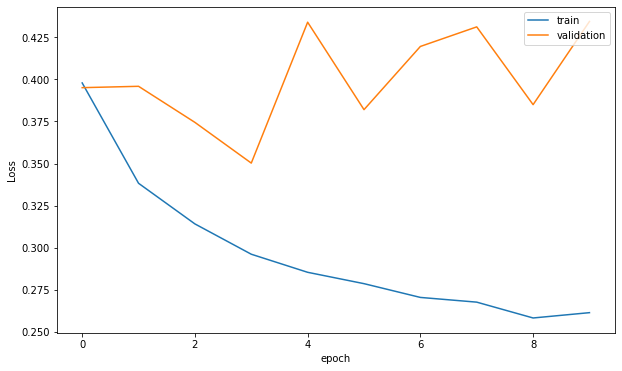

In [10]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [11]:
def classification_metrics(truedata, pred):
    print("Metrics")
    print("=======================")
    tn, fp, fn, tp = confusion_matrix(truedata, pred).ravel()
    print("True positive: ", tp)
    print("True negative: ", tn)
    print("False positive: ", fp)
    print("False negative: ", fn)
    print()
    acc = accuracy_score(truedata, pred)
    f1 = f1_score(truedata, pred)
    jaccard = jaccard_score(truedata, pred)
    sensitivity = tp / (tp + fn)
    specificity = tn / (fp + tn)
    gmean = np.sqrt(sensitivity*specificity)
    print("Accuracy: ", round(acc,3))
    print("F1 score: ", round(f1,3))
    print("Jaccard Score: ", round(jaccard,3))
    print("G-Mean: ", round(gmean,3))
    return [acc, f1, jaccard, gmean]

In [12]:
pred_dict = {}

In [13]:
pred = model.predict(test_X)
pred_dict['dense'] = np.array([round(pred[x][0]) for x in range(test_y.shape[0])])

In [14]:
column = ['Accuracy', 'F1 Score', 'Jaccard Score', 'G-Mean']
metrics = pd.DataFrame(columns=column)

temp = pd.DataFrame(classification_metrics(test_y, pred_dict['dense'])).T
temp.columns = column
metrics = pd.concat([metrics, temp], axis=0)

metrics_index = []
metrics_index.append('Dense')

Metrics
True positive:  1051
True negative:  51386
False positive:  5138
False negative:  3928

Accuracy:  0.853
F1 score:  0.188
Jaccard Score:  0.104
G-Mean:  0.438


In [15]:
tf.keras.backend.clear_session()

# LSTM model

In [16]:
train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[-1])
val_X = val_X.reshape(val_X.shape[0], 1, val_X.shape[-1])
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[-1])

In [17]:
input_shape = (1, train_X.shape[-1])

In [18]:
def lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(512, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [19]:
model = lstm_model(input_shape)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 512)            1341440   
_________________________________________________________________
dropout (Dropout)            (None, 1, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [21]:
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=verbose)

Epoch 1/10
25443/25443 [==============================] - 268s 10ms/step - loss: 0.4274 - accuracy: 0.8138 - val_loss: 0.4990 - val_accuracy: 0.8148
Epoch 2/10
25443/25443 [==============================] - 265s 10ms/step - loss: 0.3512 - accuracy: 0.8548 - val_loss: 0.3885 - val_accuracy: 0.8332
Epoch 3/10
25443/25443 [==============================] - 263s 10ms/step - loss: 0.3241 - accuracy: 0.8703 - val_loss: 0.4151 - val_accuracy: 0.8355
Epoch 4/10
25443/25443 [==============================] - 268s 11ms/step - loss: 0.3068 - accuracy: 0.8800 - val_loss: 0.4011 - val_accuracy: 0.8422
Epoch 5/10
25443/25443 [==============================] - 271s 11ms/step - loss: 0.2932 - accuracy: 0.8883 - val_loss: 0.3917 - val_accuracy: 0.8505
Epoch 6/10
25443/25443 [==============================] - 271s 11ms/step - loss: 0.2774 - accuracy: 0.8960 - val_loss: 0.4086 - val_accuracy: 0.8476
Epoch 7/10
25443/25443 [==============================] - 272s 11ms/step - loss: 0.2674 - accuracy: 0.9008

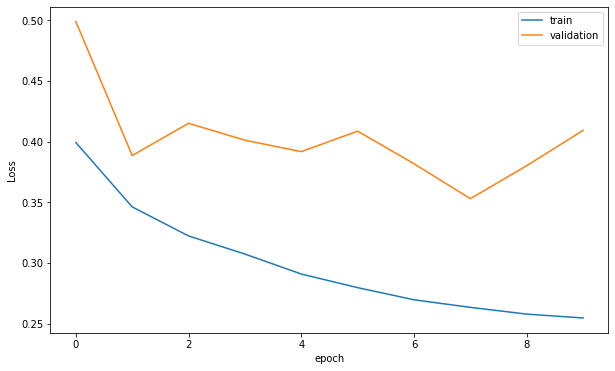

In [22]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [23]:
pred = model.predict(test_X)
pred_dict['lstm'] = np.array([round(pred[x][0]) for x in range(test_y.shape[0])])

In [24]:
temp = pd.DataFrame(classification_metrics(test_y, pred_dict['lstm'])).T
temp.columns = column
metrics = pd.concat([metrics, temp], axis=0)

metrics_index.append('LSTM')

Metrics
True positive:  1028
True negative:  51592
False positive:  4932
False negative:  3951

Accuracy:  0.856
F1 score:  0.188
Jaccard Score:  0.104
G-Mean:  0.434


In [25]:
tf.keras.backend.clear_session()

# CNN model

In [26]:
def cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=512, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(.2))
    model.add(Conv1D(filters=512, kernel_size=1, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [27]:
model = cnn_model(input_shape)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 512)            73216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 512)            0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 512)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 512)            262656    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 512)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 512)            0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

In [29]:
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=verbose)

Epoch 1/10
25443/25443 [==============================] - 133s 5ms/step - loss: 0.4374 - accuracy: 0.8093 - val_loss: 0.4247 - val_accuracy: 0.8147
Epoch 2/10
25443/25443 [==============================] - 131s 5ms/step - loss: 0.3602 - accuracy: 0.8480 - val_loss: 0.3519 - val_accuracy: 0.8603
Epoch 3/10
25443/25443 [==============================] - 131s 5ms/step - loss: 0.3368 - accuracy: 0.8601 - val_loss: 0.3872 - val_accuracy: 0.8398
Epoch 4/10
25443/25443 [==============================] - 135s 5ms/step - loss: 0.3215 - accuracy: 0.8688 - val_loss: 0.4311 - val_accuracy: 0.8247
Epoch 5/10
25443/25443 [==============================] - 133s 5ms/step - loss: 0.3082 - accuracy: 0.8746 - val_loss: 0.3853 - val_accuracy: 0.8405
Epoch 6/10
25443/25443 [==============================] - 134s 5ms/step - loss: 0.3052 - accuracy: 0.8776 - val_loss: 0.4009 - val_accuracy: 0.8373
Epoch 7/10
25443/25443 [==============================] - 135s 5ms/step - loss: 0.2984 - accuracy: 0.8816 - val_

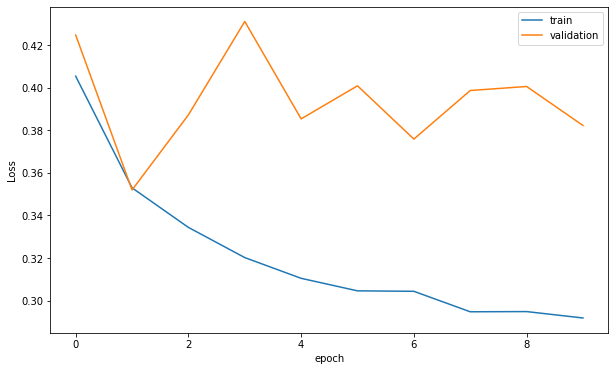

In [30]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [31]:
pred = model.predict(test_X)
pred_dict['cnn'] = np.array([round(pred[x][0]) for x in range(test_y.shape[0])])

In [32]:
temp = pd.DataFrame(classification_metrics(test_y, pred_dict['cnn'])).T
temp.columns = column
metrics = pd.concat([metrics, temp], axis=0)

metrics_index.append('CNN')

Metrics
True positive:  1011
True negative:  51865
False positive:  4659
False negative:  3968

Accuracy:  0.86
F1 score:  0.19
Jaccard Score:  0.105
G-Mean:  0.432


In [33]:
tf.keras.backend.clear_session()

# Bidirectional LSTM

In [34]:
def bilstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(256, activation='relu', return_sequences=True), input_shape=input_shape))
    model.add(Dropout(.2))
    model.add(Bidirectional(LSTM(256, activation='relu')))
    model.add(Dropout(.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [35]:
model = bilstm_model(input_shape)

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 512)            817152    
_________________________________________________________________
dropout (Dropout)            (None, 1, 512)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [37]:
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=verbose)

Epoch 1/10
25443/25443 [==============================] - 405s 16ms/step - loss: 0.4286 - accuracy: 0.8144 - val_loss: 0.4775 - val_accuracy: 0.7933
Epoch 2/10
25443/25443 [==============================] - 398s 16ms/step - loss: 0.3528 - accuracy: 0.8548 - val_loss: 0.4295 - val_accuracy: 0.8254
Epoch 3/10
25443/25443 [==============================] - 376s 15ms/step - loss: 0.3216 - accuracy: 0.8708 - val_loss: 0.3903 - val_accuracy: 0.8440
Epoch 4/10
25443/25443 [==============================] - 403s 16ms/step - loss: 0.3027 - accuracy: 0.8812 - val_loss: 0.3987 - val_accuracy: 0.8438
Epoch 5/10
25443/25443 [==============================] - 406s 16ms/step - loss: 0.2952 - accuracy: 0.8869 - val_loss: 0.3943 - val_accuracy: 0.8556
Epoch 6/10
25443/25443 [==============================] - 404s 16ms/step - loss: 0.2760 - accuracy: 0.8954 - val_loss: 0.4044 - val_accuracy: 0.8508
Epoch 7/10
25443/25443 [==============================] - 400s 16ms/step - loss: 0.2658 - accuracy: 0.9001

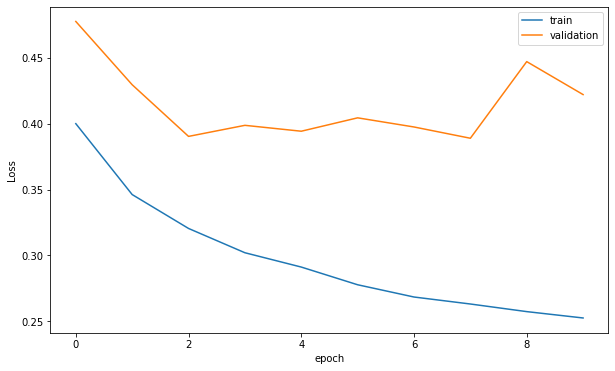

In [38]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [39]:
pred = model.predict(test_X)
pred_dict['bilstm'] = np.array([round(pred[x][0]) for x in range(test_y.shape[0])])

In [40]:
temp = pd.DataFrame(classification_metrics(test_y, pred_dict['bilstm'])).T
temp.columns = column
metrics = pd.concat([metrics, temp], axis=0)

metrics_index.append('BiLSTM')

Metrics
True positive:  1060
True negative:  51760
False positive:  4764
False negative:  3919

Accuracy:  0.859
F1 score:  0.196
Jaccard Score:  0.109
G-Mean:  0.442


In [41]:
tf.keras.backend.clear_session()

# CNN-LSTM model

In [42]:
train_X = train_X.reshape(train_X.shape[0], 1, 1, train_X.shape[-1])
test_X = test_X.reshape(test_X.shape[0], 1, 1, test_X.shape[-1])
val_X = val_X.reshape(val_X.shape[0], 1, 1, val_X.shape[-1])

In [43]:
input_shape = (None, 1, train_X.shape[-1])

In [44]:
def cnnlstm_model(input_shape):
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=512, kernel_size=1, activation='relu'), input_shape=input_shape))
    model.add(Dropout(.2))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Conv1D(filters=512, kernel_size=1, activation='relu')))
    model.add(Dropout(.2))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(512, activation='relu', return_sequences=True))
    model.add(Dropout(.2))
    model.add(LSTM(512, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [45]:
model = cnnlstm_model(input_shape)

In [46]:
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=verbose)

Epoch 1/10
25443/25443 [==============================] - 326s 13ms/step - loss: 0.4448 - accuracy: 0.8079 - val_loss: 0.3967 - val_accuracy: 0.8134
Epoch 2/10
25443/25443 [==============================] - 327s 13ms/step - loss: 0.3865 - accuracy: 0.8397 - val_loss: 0.4117 - val_accuracy: 0.7983
Epoch 3/10
25443/25443 [==============================] - 330s 13ms/step - loss: 0.3610 - accuracy: 0.8518 - val_loss: 0.4201 - val_accuracy: 0.8399
Epoch 4/10
25443/25443 [==============================] - 315s 12ms/step - loss: 0.3508 - accuracy: 0.8575 - val_loss: 0.4010 - val_accuracy: 0.8219
Epoch 5/10
25443/25443 [==============================] - 327s 13ms/step - loss: 0.3456 - accuracy: 0.8597 - val_loss: 0.4467 - val_accuracy: 0.8060
Epoch 6/10
25443/25443 [==============================] - 328s 13ms/step - loss: 0.3507 - accuracy: 0.8607 - val_loss: 0.3992 - val_accuracy: 0.8253
Epoch 7/10
25443/25443 [==============================] - 324s 13ms/step - loss: 0.3561 - accuracy: 0.8617

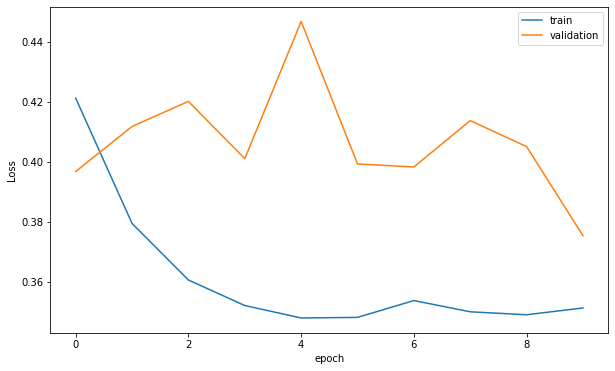

In [47]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [48]:
pred = model.predict(test_X)
pred_dict['CNN-LSTM'] = np.array([round(pred[x][0]) for x in range(test_y.shape[0])])

In [49]:
temp = pd.DataFrame(classification_metrics(test_y, pred_dict['CNN-LSTM'])).T
temp.columns = column
metrics = pd.concat([metrics, temp], axis=0)

metrics_index.append('CNN-LSTM')

Metrics
True positive:  1396
True negative:  48945
False positive:  7579
False negative:  3583

Accuracy:  0.819
F1 score:  0.2
Jaccard Score:  0.111
G-Mean:  0.493


In [50]:
tf.keras.backend.clear_session()

# Majority voting of all models

In [51]:
pred_df = pd.DataFrame(pred_dict)
pred_df['voting'] = pred_df.sum(axis=1).div(5).round(0)

temp = pd.DataFrame(classification_metrics(test_y, pred_df['voting'])).T
temp.columns = column
metrics = pd.concat([metrics, temp], axis=0)

metrics_index.append('voting')

Metrics
True positive:  1046
True negative:  51894
False positive:  4630
False negative:  3933

Accuracy:  0.861
F1 score:  0.196
Jaccard Score:  0.109
G-Mean:  0.439


# Performance

In [52]:
metrics.index = metrics_index

In [53]:
metrics

,Accuracy,F1 Score,Jaccard Score,G-Mean
Dense,0.852593,0.188216,0.103885,0.438063
LSTM,0.855568,0.187951,0.103723,0.434110
CNN,0.859730,0.189877,0.104897,0.431644
BiLSTM,0.858820,0.196242,0.108796,0.441532
CNN-LSTM,0.818513,0.200086,0.111164,0.492730
voting,0.860771,0.196340,0.108856,0.439174


# Summary 

These methods can provide a higher true negative rate but a relatively low true positive rate. It provides a higher F1 score than that using the autoencoders but a slightly lower G-Mean score. The overall performance is better than the performance using autoencoders.